In [1]:
import string
import re

import numpy as np
import pandas as pd
from statistics import mean
from scipy import stats

#--- NLP ---------------------------------------------------------------------
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer

nltk.download('punkt')
nltk.download('stopwords')

# from spacy.lang.en import English
# nlp = English()

#--- Visualization -----------------------------------------------------------
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from wordcloud import WordCloud, STOPWORDS

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
py.init_notebook_mode(connected=True)

# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter

import folium 
from folium import plugins

import joypy


#--- sklearn -----------------------------------------------------------------

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import recall_score, precision_score, auc
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV




#--- Tools -------------------------------------------------------------------
from tqdm import tqdm
from itertools import chain
from collections import Counter

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\97250\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\97250\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Utilities

fs = {'title': 15, 'axis': 12, 'legend': 12, 'ticks':9}

stop_words = stopwords.words('english')

In [3]:
# Utillity functions

def word_count(str_in):
    return len(str_in.split())

def unique_word_count(str_in):
    return len(set(str_in.split()))

def stop_word_count(str_in):
    return len([w for w in tknzr(str_in) if w in stop_words])

def mean_word_length(str_in):
    # return round(sum([len(w) for w in str_in.split()])/len(str_in.split()),0)
    return mean([len(w) for w in str_in.split()])

def get_tweets_features(df_in, col='text'):
    """ returns a df with tweets stats"""
    
    url_reg = r'(?:^|\s)https?://\S*'
    punc_reg = r'[{}]'.format(string.punctuation)
    alpha_reg = r'[a-zA-Z]'
    numeric_reg = r'[0-9]'
    
    df_out = pd.DataFrame()
    
    df_out['n_words'] = df_in[col].apply(word_count)
    df_out['n_setwords'] = df_in[col].apply(unique_word_count)
    df_out['n_stopwords'] = df_in[col].apply(stop_word_count)
    df_out['mean_word_len'] = df_in[col].apply(mean_word_length)

    df_out['n_#'] = df_in[col].str.count('#')
    df_out['n_@'] = df_in[col].str.count('@')
    df_out['n_chars'] = df_in[col].str.len()
    df_out['n_url'] = df_in[col].str.count(url_reg)
    df_out['n_punc'] = df_in[col].str.count(punc_reg)
    df_out['n_alpha'] = df_in[col].str.count(alpha_reg)
    df_out['n_numeric'] = df_in[col].str.count(numeric_reg)
    
    return df_out


def category_analysis(df_in, col, target, min_occur=0):
    """
    input:  df_in - dataframe which contains the columns: col and target
                    the categories in col are assumed to be processed. 
            min_occur - number of times the class appears (by default = 10)
    
    """
    df_classes = pd.DataFrame()
    df_classes['count'] = df_in.groupby(col)[target].count().sort_values(
        ascending=False)

    for t in df_in[target].unique():
        df_classes[t] = df_in[df_in[target]==t].groupby(col)[target].count()
        
    df_classes = df_classes[df_classes['count'] > min_occur]
    df_classes.fillna(value=0, inplace=True)
    return df_classes

In [6]:
data_path = r"../../checkpoint3/train_data.csv"

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Product-Description" data-toc-modified-id="Product-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Product Description</a></span><ul class="toc-item"><li><span><a href="#Background-and-Information" data-toc-modified-id="Background-and-Information-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Background and Information</a></span></li><li><span><a href="#Key-Demographics" data-toc-modified-id="Key-Demographics-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Key Demographics</a></span></li><li><span><a href="#Benefits" data-toc-modified-id="Benefits-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Benefits</a></span></li><li><span><a href="#Usage" data-toc-modified-id="Usage-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Usage</a></span></li><li><span><a href="#Success-Metrics-and-KPI's" data-toc-modified-id="Success-Metrics-and-KPI's-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Success Metrics and KPI's</a></span></li></ul></li><li><span><a href="#Questions-and-Hypothesis" data-toc-modified-id="Questions-and-Hypothesis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Questions and Hypothesis</a></span><ul class="toc-item"><li><span><a href="#Questions" data-toc-modified-id="Questions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Questions</a></span></li><li><span><a href="#Hypothesis" data-toc-modified-id="Hypothesis-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Hypothesis</a></span></li></ul></li><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Exploration</a></span><ul class="toc-item"><li><span><a href="#Loading-data" data-toc-modified-id="Loading-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Loading data</a></span></li><li><span><a href="#Exploration" data-toc-modified-id="Exploration-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Exploration</a></span><ul class="toc-item"><li><span><a href="#Missing-Values" data-toc-modified-id="Missing-Values-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Missing Values</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Keyword-&amp;-Locations" data-toc-modified-id="Keyword-&amp;-Locations-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Keyword &amp; Locations</a></span></li></ul></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Visualization</a></span><ul class="toc-item"><li><span><a href="#Keywords-&amp;-Locations" data-toc-modified-id="Keywords-&amp;-Locations-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Keywords &amp; Locations</a></span></li><li><span><a href="#Word-Cloud" data-toc-modified-id="Word-Cloud-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Word Cloud</a></span><ul class="toc-item"><li><span><a href="#Meta-Features" data-toc-modified-id="Meta-Features-3.3.2.1"><span class="toc-item-num">3.3.2.1&nbsp;&nbsp;</span>Meta Features</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Baseline Model</a></span><ul class="toc-item"><li><span><a href="#Words-Based-Models" data-toc-modified-id="Words-Based-Models-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Words Based Models</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Logistic Regression</a></span><ul class="toc-item"><li><span><a href="#basic-model" data-toc-modified-id="basic-model-4.1.1.1"><span class="toc-item-num">4.1.1.1&nbsp;&nbsp;</span>basic model</a></span></li><li><span><a href="#Grid-search" data-toc-modified-id="Grid-search-4.1.1.2"><span class="toc-item-num">4.1.1.2&nbsp;&nbsp;</span>Grid search</a></span></li><li><span><a href="#Exploring-model-outcome" data-toc-modified-id="Exploring-model-outcome-4.1.1.3"><span class="toc-item-num">4.1.1.3&nbsp;&nbsp;</span>Exploring model outcome</a></span></li><li><span><a href="#Error-Exploration" data-toc-modified-id="Error-Exploration-4.1.1.4"><span class="toc-item-num">4.1.1.4&nbsp;&nbsp;</span>Error Exploration</a></span></li></ul></li><li><span><a href="#Interim-findings-and-next-steps-based-on-basic-model" data-toc-modified-id="Interim-findings-and-next-steps-based-on-basic-model-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Interim findings and next steps based on basic model</a></span></li></ul></li><li><span><a href="#Data-Normalization" data-toc-modified-id="Data-Normalization-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Data Normalization</a></span><ul class="toc-item"><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Logistic regression</a></span></li><li><span><a href="#Random-Forest-on-cleaned-data" data-toc-modified-id="Random-Forest-on-cleaned-data-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Random Forest on cleaned data</a></span></li><li><span><a href="#Voting" data-toc-modified-id="Voting-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Voting</a></span></li></ul></li><li><span><a href="#Interim-findings-and-next-steps-based-on-basic-model" data-toc-modified-id="Interim-findings-and-next-steps-based-on-basic-model-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Interim findings and next steps based on basic model</a></span></li></ul></li></ul></div>

# Product Description

## Background and Information

Global warming, world terror, epidemic outbreak and other emergencies have become more frequent in recent years[Ref](https://www.emdat.be).

When considering the 4 main stages in emergency management - **Planning and Preparedness**, **Prevention and Mitigation**, followed by **Response** and finally **Impact and Recovery** - relevant information is crucial in each stage and can literally **save lives**.

The advances in technology and communication enable citizens, municipalities, governments and emergency services to be informed in real time, which in turn allows for quick response. 
However, the flood of information in general and misinformation in particular makes it difficult (for all stakeholders) to identify and filter the reliable and relevant information regarding emergencies. 

**"In the absence of timely and accurate information, some turned to social media for updates - only to be confronted by misinformation."** ([Ref](https://www.ubcm.ca/assets/Events/EAD~2018/Provincial%20Disaster%20Response%20BC%20Flood%20Wildfire%20Review.pdf))

On Tweeter, a **Tweeter Emergency** is a feed which provides tweets from verified account which were classified as accurate, relevant and should be shared ([Ref](https://edition.cnn.com/2013/09/25/tech/twitter-emergency-tweets/index.html)). 
This feed allows emergency services, municipalities, relief organizations and news outlets to monitor and control the stream of information regarding emergencies and to limit exposure to misinformation which might create panic and confusion that will escalate the situation.

As recommended by the New York Times ([Ref](https://www.nytimes.com/2017/09/21/travel/social-media-emergencies.html)): **"The key to using Twitter and Facebook in travel emergencies is choosing the right people, groups and companies to follow"**.
The existing approach for identifying and broadcasting information regarding emergencies focuses on user responsibility and reliability.

The goal of this project is to provide a Machine Learning based automated solution to establish emergency tweets credibility and relevance in order to identify and broadcast reliable emergency information on Tweeter (and on other social media platforms in the future).  


## Key Demographics

Since the suggested solution is intended to solve a specific problem, the character and features of the suggested solution are determined based on the needs and requirements of the prospected costumers and users. These users are most likely to be:
* Populations in danger - although this product is not directly intended for populations in danger, these are the *end users* of this product which is intended eventually to save more lives and reduce damages. By making reliable emergency information accessible, people will be able to prepare and react accordingly (avoid wildfire areas, go around flooded roads etc.) 
* Tweeter - providing a filter platform for the emergency tweets feed would improve its usage and impact. 
* Emergency services - identifying real emergencies would lead to an efficient resources allocation and will save time and women power by responding only to real emergencies.
* Authorities (global, federal and local) - at a time of crises most citizens turn to the authorities, expecting reliable information and evacuation or rescue if needed. This product will enable a quick and accurate response on their part.
* News outlets - despite the decline in traditional media, news outlets are the only source for reliable information. This product will enable better and faster coverage of emergencies in real time.

## Benefits

As mentioned above, the main benefits are:
* Tweeter:
    - Branding - establish tweeter as the 'go to' platform for information
    - Increase profitability - more traffic on tweeter, new market segments
    - Community engagement - creating a positive impact in a global level
* Emergency services performances:
    - Improving response time
    - Increasing efficiency
    - Reducing costs
* Authorities reliability:
    - Provide expected public services and protection
    - Impact and improve community life
* News outlets
    - Establish credibility
    - Increase relevance
    - Improve coverage and reduce costs
    

## Usage

The product is intended to be used as a filtering layer in emergency feeds.
In a similar way to spam filters - tweets that are determined relevant would pass through and non relevant tweets will be directed to a 'spam' directory, where they would be reviewed to identify false negatives and to improve the performances of the product.
This will require more research and better understanding of emergency notification platform which will done in the coming days/weeks.


## Success Metrics and KPI's

* In the first stage of the product development, our main focus is to minimize the False Negatives (using the recall metric).
* Since our resources are limited, in the next stage we would like to create a cost based decision model, which will quantify the impact of False Positives and False Negatives of our product. This will provide a probability and expected cost, allowing the customer to make an educated decision based on her role and available resources.

# Questions and Hypothesis

## Questions
Prior to analyzing the data the following questions were asked:
1. What is the distribution of the target variable and the various features?
2. Is the data balanced or not?
3. Which cases are easily identified as emergencies and which are not?
4. What kind of external enrichment can contribute? Which elements require such enrichment are which don't?

## Hypothesis
Before and during our exploratory data analysis and preprocessing, a few theories and hypothesis were brought up regarding the date and the model:
1. Keywords - certain keywords and phrases appear more frequently in emergency tweets and other in non emergency tweets.
2. Patterns - there are writing and phrasing patterns that are typical for emergency and non emergency tweets.
3. Entities - real emergency tweets will be associated with certain entities while non emergency tweets will be associated with others.
4. Sentiment - emergency tweets and non emergency tweets will have different sentiments and context in them.
5. Morphology - tweet morphology is related to the tweet classification as real or non real emergency tweet (all upper case letters, multiple exclamation marks etc.)
6. Visualization - the presence of an image in a tweet, and its content, would indicate where a tweet is an emergency tweet or not.

# Data Exploration

Data exploration and findings description. For each group, there should be many such findings. Present them in 2-3 pages long based on your Jupyter Notebooks with the findings, query justifying it, intuition for it and an example/visualization.

Examples:

* “We have found that our text data contains a large amount of typos; 27% of our words are not in a standard English dictionary”
* “We have found that lightning conditions change dramatically between times of the day”
* “We have found that the camera position had slight changes from day to day.”
* “The cashier capturing sales data was malfunctioning between some dates, leading to X% less reported sales”
* “The images we are working with came from two different types of MRI machines, and these different types have the following biases…”

## Loading data

In [8]:
df_train = pd.read_csv(data_path)
df_train.sample(5)

,id,keyword,location,text,target
1635,2362,collapsed,"CAMARILLO, CA",@organicallyrude @1ROCKSTAR62 #wish Mattingly ...,1
4172,5927,harm,NaN,@news4buffalo yes a lot more harm then good if...,0
3659,5209,fatalities,"Lima, Ohio",Message boards will display updated traffic fa...,1
3576,5109,famine,NaN,@Surf_Photo I squeezed a tear. Famine plague t...,0
6668,9556,threat,"Kwajalein/Virginia/Dayton, OH",@dmassa5 Definite triple crown threat. Him and...,1


In [9]:
features = ['keyword', 'location', 'text']
target = ['target']

## Exploration

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [11]:
df_train.target.value_counts(normalize = True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [12]:
df_plots = df_train.copy()

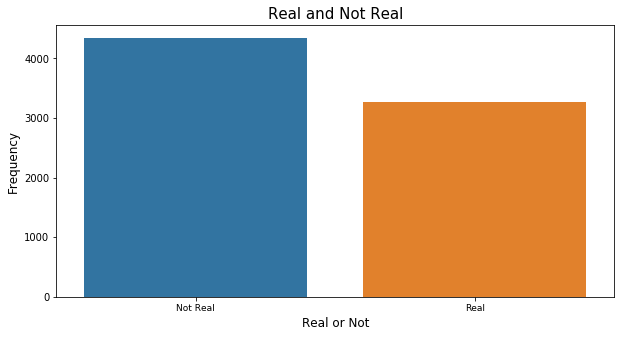

In [13]:
# Target distribution
fig, ax = plt.subplots(1,1, figsize=(10,5))

sns.countplot(x="target", data=df_plots, ax=ax)
ax.set_title("Real and Not Real", fontsize=fs['title'])
ax.set_xlabel("Real or Not", fontsize=fs['axis'])
ax.set_ylabel("Frequency", fontsize=fs['axis'])
ax.set_xticklabels(['Not Real', 'Real'], fontsize=fs['ticks'])
plt.show()

### Missing Values

* Dealing with missing values:
    - **keyword**: 0.8% missing. Adding category `NoKey`. 
    - **location**: 33.27% missing. Replacing `NA` values with `NoLoc`

In [14]:
df_missing = pd.DataFrame(df_train.isna().sum() / len(df_train) * 100, 
                          columns=['all'])
df_missing['real'] = df_train[df_train.target==1].isna().sum()\
                            / len(df_train[df_train.target==1]) * 100
df_missing['not_real'] = df_train[df_train.target==0].isna().sum()\
                            / len(df_train[df_train.target==0]) * 100

df_missing

,all,real,not_real
id,0.000000,0.000000,0.000000
keyword,0.801261,1.284011,0.437586
location,33.272035,32.864567,33.578996
text,0.000000,0.000000,0.000000
target,0.000000,0.000000,0.000000


### Feature Engineering

In [15]:
tknzr = TfidfVectorizer(encoding = 'latin1').build_analyzer()
df_train['Token'] = df_train.text.apply(tknzr)
df_train['Token_text'] = df_train.Token.str.join(' ')

In [16]:
# df_train.sample(10)

In [17]:
df_train_stats = get_tweets_features(df_train, col='text')
df_train_stats['target'] = df_train['target']

### Keyword & Locations

In [15]:
df_train['keyword'] = df_train.keyword.fillna('NoKey')
df_train['location'] = df_train.location.fillna('NoLoc')

In [16]:
df_kw = category_analysis(df_train, 'keyword', 'target')
df_kw.columns = ['count', 'real', 'not_real']

In [17]:
df_loc = category_analysis(df_train, 'location', 'target')
df_loc.columns = ['count', 'real', 'not_real']

## Visualization

### Keywords & Locations

In [18]:
min_count = 10
max_kw = 45
max_loc = 45

df_p_kw = df_kw.iloc[:max_kw, :].copy()
df_p_kw[['real_%', 'not_real_%']] = df_p_kw[['real', 'not_real']].divide(
    df_p_kw['count'], axis=0)
df_p_kw.sort_values(by='real_%', axis=0, inplace=True)

df_p_loc = df_loc.iloc[:max_loc, :].copy()
df_p_loc[['real_%', 'not_real_%']] = df_p_loc[['real', 'not_real']].divide(
    df_p_loc['count'], axis=0)
df_p_loc.sort_values(by='real_%', axis=0, inplace=True)

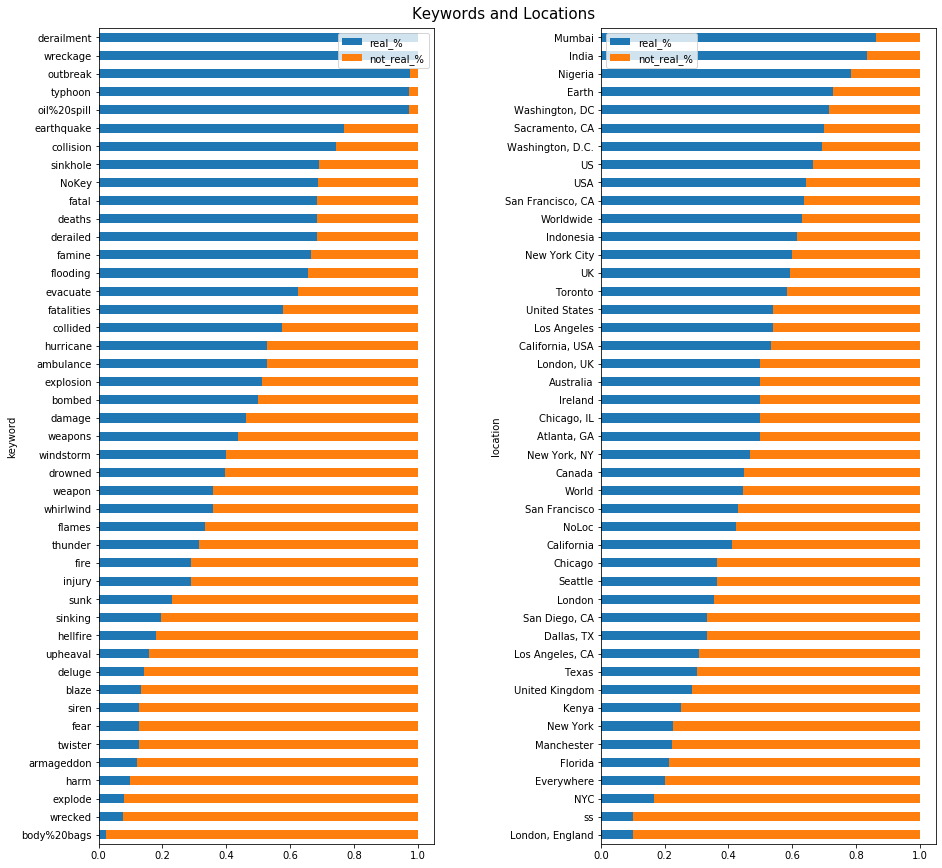

In [19]:
# Plot: keywords and locations
f, ax = plt.subplots(1,2,figsize=(15, 15))

# plotting keywords
df_p_kw[['real_%', 'not_real_%']].plot(kind='barh', stacked=True, ax=ax[0])
# plotting locations
df_p_loc[['real_%', 'not_real_%']].plot(kind='barh', stacked=True, ax=ax[1])

plt.suptitle('Keywords and Locations', fontsize=fs['title'], y=0.9)
plt.subplots_adjust(wspace=0.5)
plt.show()

### Word Cloud

In [20]:
# word clouds

all_locs = " ".join(df_train['location'].to_list())
real_locs = " ".join(df_train[df_train.target==1]['location'].to_list())
not_real_locs = " ".join(df_train[df_train.target==0]['location'].to_list())

all_keys = " ".join(df_train['keyword'].to_list())
real_keys = " ".join(df_train[df_train.target==1]['keyword'].to_list())
not_real_keys = " ".join(df_train[df_train.target==0]['keyword'].to_list())

all_words = " ".join(list(chain.from_iterable(df_train['Token'].to_list())))
real_words = " ".join(list(chain.from_iterable(df_train[df_train.target==1]['Token'].to_list())))
not_real_words = " ".join(list(chain.from_iterable(df_train[df_train.target==0]['Token'].to_list())))


locscloud = WordCloud(width = 1000, height = 500, 
                      background_color ='white', 
                      stopwords = stop_words, 
                      min_font_size = 10).generate(all_locs)
locscloud_real = WordCloud(width = 1000, height = 500, colormap="OrRd", 
                      background_color ='white', 
                      stopwords = stop_words, 
                      min_font_size = 10).generate(real_locs)
locscloud_not_real = WordCloud(width = 1000, height = 500, colormap="BuPu",
                      background_color ='white', 
                      stopwords = stop_words, 
                      min_font_size = 10).generate(not_real_locs)


keyscloud = WordCloud(width = 1000, height = 500, 
                      background_color ='white', 
                      stopwords = stop_words, 
                      min_font_size = 10).generate(all_keys)
keyscloud_real = WordCloud(width = 1000, height = 500, colormap="OrRd", 
                      background_color ='white', 
                      stopwords = stop_words, 
                      min_font_size = 10).generate(real_keys)
keyscloud_not_real = WordCloud(width = 1000, height = 500, colormap="BuPu",
                      background_color ='white', 
                      stopwords = stop_words, 
                      min_font_size = 10).generate(not_real_keys)


wordcloud = WordCloud(width = 1000, height = 500, 
                      background_color ='white', 
                      stopwords = stop_words, 
                      min_font_size = 10).generate(all_words)
wordcloud_real = WordCloud(width = 1000, height = 500, colormap="OrRd", 
                      background_color ='white', 
                      stopwords = stop_words, 
                      min_font_size = 10).generate(real_words)
wordcloud_not_real = WordCloud(width = 1000, height = 500, colormap="BuPu",
                      background_color ='white', 
                      stopwords = stop_words, 
                      min_font_size = 10).generate(not_real_words)

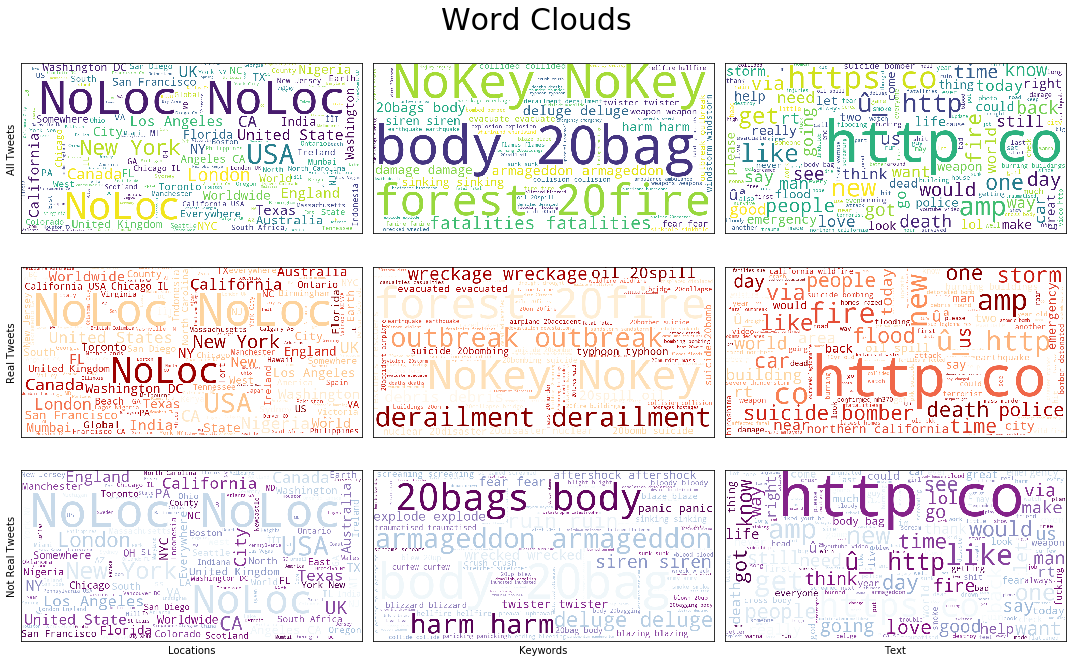

In [21]:
# Plot: locations, keys, text word clouds
fig, ax = plt.subplots(3,3, figsize = (15, 10), facecolor = None, sharex=True, sharey=True)

ax[0,0].imshow(locscloud) 
ax[0,0].set(ylabel='All Tweets')
plt.setp(ax[0,0].get_xticklabels(), visible=False)
plt.setp(ax[0,0].get_yticklabels(), visible=False)
ax[0,0].tick_params(axis='both', which='both', length=0)

ax[1,0].imshow(locscloud_real) 
ax[1,0].set(ylabel='Real Tweets')
plt.setp(ax[1,0].get_xticklabels(), visible=False)
plt.setp(ax[1,0].get_yticklabels(), visible=False)
ax[1,0].tick_params(axis='both', which='both', length=0)

ax[2,0].imshow(locscloud_not_real) 
ax[2,0].set(xlabel='Locations', ylabel='Not Real Tweets')
plt.setp(ax[2,0].get_xticklabels(), visible=False)
plt.setp(ax[2,0].get_yticklabels(), visible=False)
ax[2,0].tick_params(axis='both', which='both', length=0)

ax[0,1].imshow(keyscloud) 
plt.setp(ax[0,1].get_xticklabels(), visible=False)
plt.setp(ax[0,1].get_yticklabels(), visible=False)
ax[0,1].tick_params(axis='both', which='both', length=0)

ax[1,1].imshow(keyscloud_real) 
plt.setp(ax[1,1].get_xticklabels(), visible=False)
plt.setp(ax[1,1].get_yticklabels(), visible=False)
ax[1,1].tick_params(axis='both', which='both', length=0)

ax[2,1].imshow(keyscloud_not_real)
ax[2,1].set(xlabel='Keywords')
plt.setp(ax[2,1].get_xticklabels(), visible=False)
plt.setp(ax[2,1].get_yticklabels(), visible=False)
ax[2,1].tick_params(axis='both', which='both', length=0)

ax[0,2].imshow(wordcloud) 
plt.setp(ax[0,2].get_xticklabels(), visible=False)
plt.setp(ax[0,2].get_yticklabels(), visible=False)
ax[0,2].tick_params(axis='both', which='both', length=0)

ax[1,2].imshow(wordcloud_real) 
plt.setp(ax[1,2].get_xticklabels(), visible=False)
plt.setp(ax[1,2].get_yticklabels(), visible=False)
ax[1,2].tick_params(axis='both', which='both', length=0)

ax[2,2].imshow(wordcloud_not_real)
ax[2,2].set(xlabel='Text')
plt.setp(ax[2,2].get_xticklabels(), visible=False)
plt.setp(ax[2,2].get_yticklabels(), visible=False)
ax[2,2].tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.suptitle('Word Clouds', fontsize=fs['title']*2)
plt.subplots_adjust(hspace=-0.3)
plt.show()

#### Meta Features

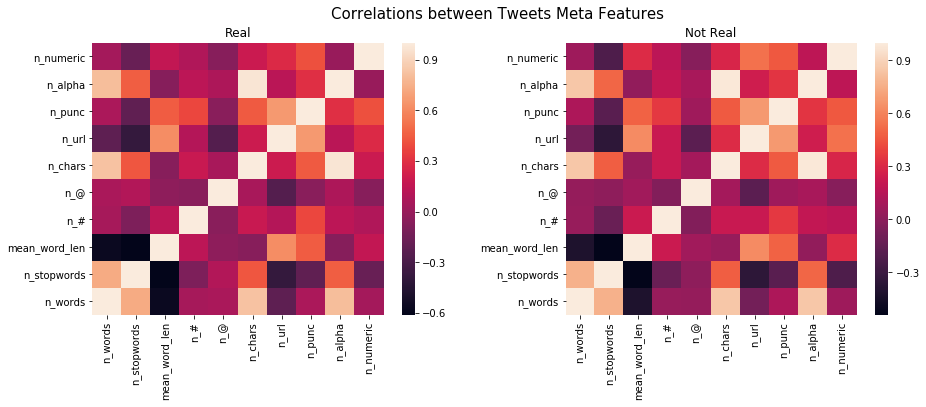

In [22]:
# Plot: heatmap

fig, ax = plt.subplots(1,2, figsize=(15,5))

corr_cols = (df_train_stats.columns != 'target') & (df_train_stats.columns != 'n_setwords')
sns.heatmap(data=np.corrcoef(df_train_stats.loc[df_train_stats['target']==1,corr_cols].T), 
            yticklabels=df_train_stats.columns[corr_cols],
            xticklabels=df_train_stats.columns[corr_cols],
            ax=ax[0])
ax[0].set_ylim(0, 10)
ax[0].set_xlim(0, 10)
ax[0].set_title('Real')

sns.heatmap(data=np.corrcoef(df_train_stats.loc[df_train_stats['target']==0,corr_cols].T),             
            yticklabels=df_train_stats.columns[corr_cols],
            xticklabels=df_train_stats.columns[corr_cols],
            ax=ax[1])
ax[1].set_ylim(0, 10)
ax[1].set_xlim(0, 10)
ax[1].set_title('Not Real')

plt.suptitle('Correlations between Tweets Meta Features', fontsize=fs['title'])
plt.subplots_adjust(wspace=0.3)
plt.show()

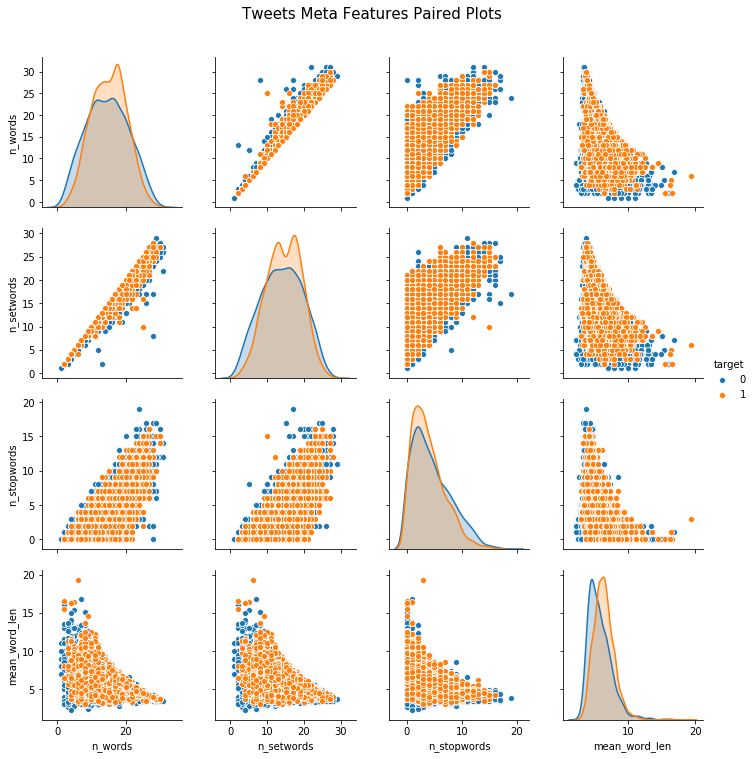

In [23]:
# Plot: paired distributions - part 1

g = sns.pairplot(data=df_train_stats, hue='target',  kind='scatter', height=2.5,
             vars=['n_words', 'n_setwords', 'n_stopwords', 'mean_word_len'])
g.fig.suptitle('Tweets Meta Features Paired Plots', y=1.05, fontsize=fs['title'])
plt.show()

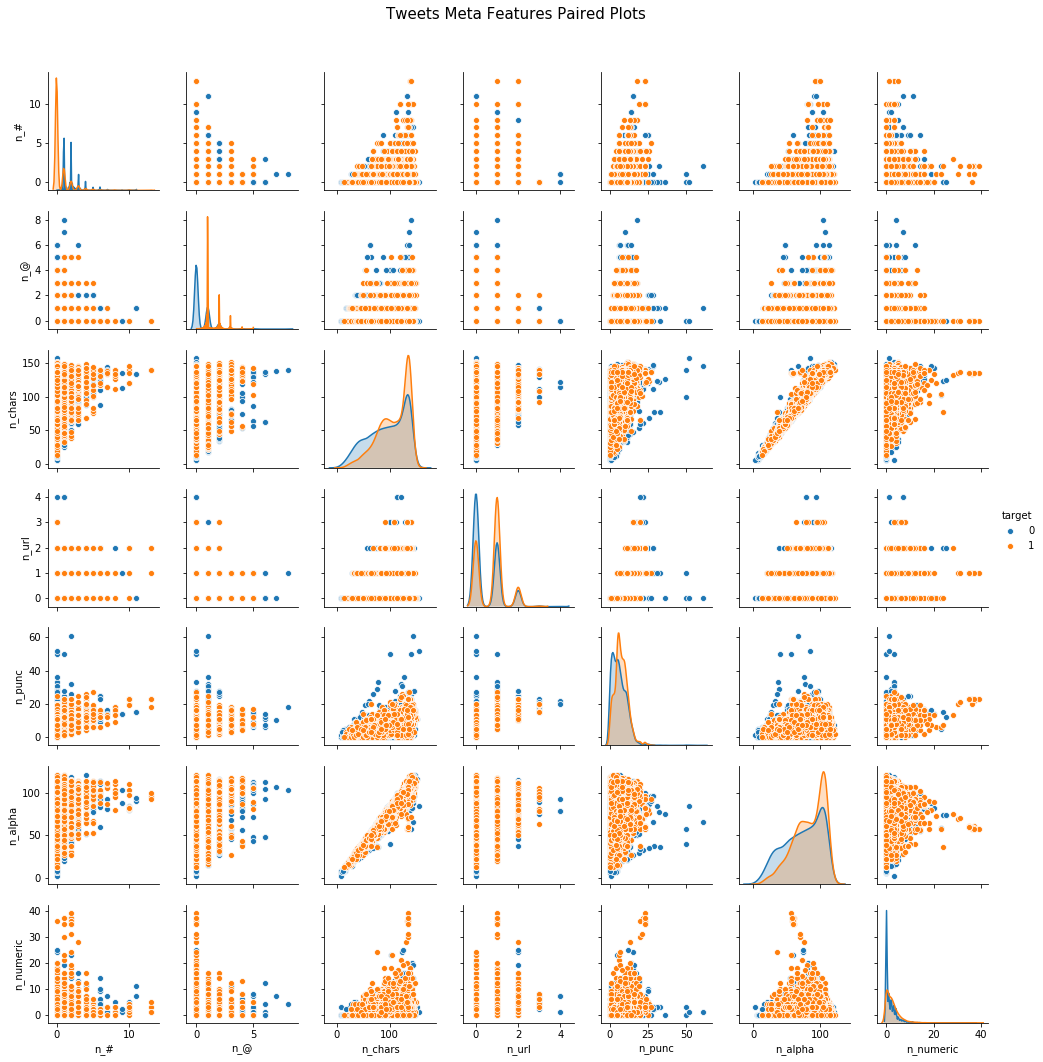

In [24]:
# Plot: paired distributions - part 2

g = sns.pairplot(data=df_train_stats, hue='target',  kind='scatter', height=2,
             vars=['n_#', 'n_@', 'n_chars', 'n_url', 'n_punc', 'n_alpha', 'n_numeric'])
g.fig.suptitle('Tweets Meta Features Paired Plots', y=1.05, fontsize=fs['title'])
plt.show()

# Baseline Model

This is likely 2-4 pages long with images/screenshots. 

For example, describe what you did to show:
* How you “featurized” the text and that you used a simple linear model to show that your text classification model has accuracy 85%, where the naive predictor (i.e. majority class) would have predicted 77%.
* How you leveraged a pre-trained object detection library to prove that you can detect the relevant objects with precision 80% and recall 75%.

In [25]:
def evaluate_model(model, X_test, y_true, recall_th = 0.8):
     
    y_proba = model.predict_proba(X_test)[:,1]

    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    average_precision = average_precision_score(y_true, y_proba)
    
    th = float(thresholds[np.argwhere(recall > recall_th).max()])
    print(f'For recall of {recall_th} the precision is: {float(precision[np.argwhere(recall > recall_th).max()]):.3f}')
    print(f'For recall of {recall_th} the threshold is: {th:.3f}')
        
    y_pred = np.zeros_like(y_true)
    y_pred[y_proba > th] =1

    base_line = (y_true==1).sum() / len(y_true)

    print(f'PC AUC: {average_precision:.3f}')
    
    plt.plot([0, 1], [base_line, base_line], linestyle='--', label='true prob')
    plt.plot(recall, precision, marker='.', label = 'Logistic')

    plt.title(f'PR AUC (Logistic Regression) = {average_precision:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
    
    return y_pred

In [26]:
# The features:

def top_features_lgr(model, n=50):

    word_importance = pd.DataFrame(
        {'word': list(model['preprocess'].get_feature_names()), 
         'coef': model['model'].coef_[0]})

    top_real = word_importance.nlargest(n, 'coef').sort_values(
                                              by='coef', ascending=False).reset_index(drop=True)
    top_not_real = word_importance.nsmallest(n, 'coef').sort_values(
                                                   by='coef', ascending=True).reset_index(drop=True)

    top_n = pd.concat([top_real, top_not_real],
                      axis=1, ignore_index=True)

    columns = [('real', 'words'),('real', 'coef'),('not_real', 'words'),('not_real', 'coef')]
    top_n.columns = pd.MultiIndex.from_tuples(columns)

    return top_n

In [27]:
def top_features_boost(model, n=50):
    word_importance = pd.DataFrame(
        {'word': list(model['preprocess'].get_feature_names()), 
         'importance': model['gbm'].feature_importances_}).nlargest(n, 'importance').sort_values(
                                              by='importance', ascending=False).reset_index(drop=True)

    return word_importance

In [119]:
def error_explor(df, X, y_true, y_pred, model, to_explore= 'TP'):
    
    word_importance = pd.DataFrame(
        {'word': list(model['preprocess'].get_feature_names()), 
         'coef': model['model'].coef_[0]})
        
    if to_explore == 'TP':
        tweets_ind = X[(y_true == 1) & (y_pred==1)].index
        
    elif to_explore == 'TN':
        tweets_ind = X[(y_true == 0) & (y_pred==0)].index
        
    elif to_explore == 'FP':
        tweets_ind = X[(y_true == 0) & (y_pred==1)].index
    
    elif to_explore == 'FN':
        tweets_ind = X[(y_true == 1) & (y_pred==0)].index
    
    idx = np.random.choice(tweets_ind)
    print(f'Explore {to_explore}, index: {idx}:\n')
    org_sent = df[idx]
    print('Sentance:\n-----------------\n',org_sent, '\n-----------------')
    
    sent= X[idx]
    
    tknzr = TfidfVectorizer(encoding = 'latin1').build_analyzer()
    sent_token = tknzr(sent)
    print('Sentance Token:\n-----------------\n',sent_token, '\n-----------------')
    
    print('Features:\n-----------------')
    ind = np.argwhere(model['preprocess'].transform([sent])> 0)[:,1].tolist()
    print(word_importance.loc[ind])

    print('\nPrediction:\n\t0\t1\n------------------------------')
    print(model.predict_proba([sent])[0])


## Words Based Models

In [29]:
X = df_train.text
y = df_train.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

### Logistic Regression

#### basic model

In [30]:
pipeline_lgr = Pipeline(steps = [('preprocess', TfidfVectorizer(max_features= 200, encoding='latin-1', analyzer='word', stop_words ='english', ngram_range=(1,1))),
                   ('model', LogisticRegression(C=1, class_weight='balanced', penalty='l1', solver='liblinear'))])

pipeline_lgr.fit(X_train, y_train)
preds = pipeline_lgr.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.77      0.74      0.75       874
           1       0.67      0.71      0.69       649

    accuracy                           0.72      1523
   macro avg       0.72      0.72      0.72      1523
weighted avg       0.73      0.72      0.72      1523



#### Grid search

In [31]:
param_grid_lgr = {
    'preprocess__min_df': list(range(2, 5)),
    'preprocess__ngram_range': [(1, 1), (2, 2), (3,3), (4, 4), (1, 5)],
    'preprocess__stop_words': [None, 'english'],
    'preprocess__max_features': [10, 200, 400, 800, 1000],
    'model__C': [1, 10, 100],
    'model__penalty': ['l1', 'l2']
}

cv = KFold(n_splits=5, shuffle=True, random_state=44)

In [32]:
grd_lgr = RandomizedSearchCV(pipeline_lgr, param_grid_lgr, cv=cv, n_iter=10, refit=True,random_state=45, return_train_score=False)
grd_lgr.fit(X_train, y_train);

C:\Users\Asus\Anaconda3\envs\py36\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Asus\Anaconda3\envs\py36\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [33]:
# print('Mean cv best estimator={}'.format(grd.best_estimator_))
print('Mean cv score of best estimator={}'.format(grd_lgr.best_score_))
print('Best params={}'.format(grd_lgr.best_params_))

Mean cv score of best estimator=0.7817733990147785
Best params={'preprocess__stop_words': None, 'preprocess__ngram_range': (1, 1), 'preprocess__min_df': 3, 'preprocess__max_features': 800, 'model__penalty': 'l2', 'model__C': 1}


In [34]:
basic_model_lgr = grd_lgr.best_estimator_

#### Exploring model outcome

For recall of 0.8 the precision is: 0.667
For recall of 0.8 the threshold is: 0.419
PC AUC: 0.836


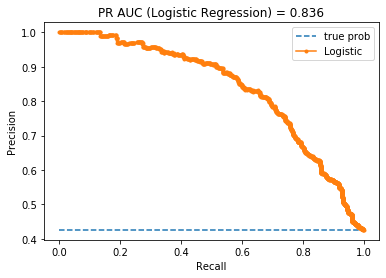

In [35]:
y_pred = evaluate_model(grd_lgr, X_test, y_test, recall_th = 0.8)

In [36]:
top_features_lgr(basic_model_lgr, 50).head(10)

real             not_real          
        words      coef      words      coef
0   hiroshima  3.558174        you -2.713486
1       fires  2.932252       full -2.544085
2     suicide  2.744474         my -2.110170
3  california  2.572554        new -1.994897
4    wildfire  2.554850       ebay -1.782921
5  earthquake  2.487690       your -1.715715
6      killed  2.395937     blight -1.687775
7    massacre  2.389855  screaming -1.671708
8  derailment  2.361825        let -1.629925
9        mass  2.326208       bags -1.552686

#### Error Exploration

In [120]:
error_explor(df_train.text, X_test, y_test, y_pred, basic_model_lgr, "TP")

Explore TP, index: 7328:

Sentance:
-----------------
 Route Complex AM Fire Update (Route Complex Wildfire): FIRE UPDATE: ROUTE COMPLEX Thursday Morning Aug... http://t.co/nS5lBS5ZUp #CAFire 
-----------------
Sentance Token:
-----------------
 ['route', 'complex', 'am', 'fire', 'update', 'route', 'complex', 'wildfire', 'fire', 'update', 'route', 'complex', 'thursday', 'morning', 'aug', '__url__', '__h__'] 
-----------------
Features:
-----------------
         word      coef
41         am -0.755490
68        aug  1.228498
278      fire  1.772772
720    update  1.318456
766  wildfire  2.554850

Prediction:
	0	1
------------------------------
[0.09829072 0.90170928]


In [63]:
error_explor(df_train.text, X_test, y_test, y_pred, basic_model_lgr, "TN")

Explore TN, index: 4660:

Sentance:
-----------------
 Brace yourself @samaritans by Sunday evening you will inundated with thousands of calls from depressed @Arsenal fans http://t.co/HexPc77otN 
-----------------
Sentance Token:
-----------------
 ['brace', 'yourself', '__m__', 'by', 'sunday', 'evening', 'you', 'will', 'inundated', 'with', 'thousands', 'of', 'calls', 'from', 'depressed', '__m__', 'fans', '__url__'] 
-----------------
Features:
-----------------
          word      coef
131         by  0.291651
292       from  1.374257
377  inundated -0.235762
495         of  0.893389
767       will  0.354956
771       with -0.826903
790        you -2.713486
792   yourself -0.426901

Prediction:
	0	1
------------------------------
[[0.73325584 0.26674416]]


In [39]:
error_explor(df_train.text, X_test, y_test, y_pred, basic_model_lgr, "FP")

Explore FP, index: 3532:

Sentance:
-----------------
 A true #TBT  Eyewitness News WBRE WYOU http://t.co/JHVigsX5Jg 
-----------------
Sentance Token:
-----------------
 ['true', 'tbt', 'eyewitness', 'news', 'wbre', 'wyou', 'http', 'co', 'jhvigsx5jg'] 
-----------------
Features:
-----------------
           word      coef
163          co  0.215603
259  eyewitness -0.173060
363        http  0.726148
480        news  0.814811

Prediction:
	0	1
------------------------------
[0.49861271 0.50138729]


In [143]:
error_explor(df_train.text, X_test, y_test, y_pred, basic_model_lgr, "FN")

Explore FN, index: 6119:

Sentance:
-----------------
 That horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time 
-----------------
Sentance Token:
-----------------
 ['that', 'horrible', 'sinking', 'feeling', 'when', '__u__', 'been', 'at', 'home', 'on', 'your', 'phone', 'for', 'while', 'and', 'you', 'realise', 'its', 'been', 'on', '__d__g', 'this', 'whole', 'time'] 
-----------------
Features:
-----------------
         word      coef
48        and -0.705105
64         at  1.248685
89       been  0.650899
288       for  0.050491
351      home  1.427616
354  horrible  0.864412
387       its -0.227870
503        on  0.600254
524     phone -0.436218
619   sinking -0.764049
671      that -0.162295
682      this  0.088654
689      time -0.679102
756      when  0.917126
759     while  0.312325
763     whole  0.286879
790       you -2.713486
791      your -1.715715

Prediction:
	0	1
------------------------------
[0.5790

### Interim findings and next steps based on basic model

The following insights were achieved as a result of the exploratory data analysis:

1. There is a bias as a result of certain words and characters that should not have by itself a meaning of whether the text is real or not, for e.g. HTTP/S, digits, dates, etc. Therefore as a first step, we would like to 'normalize' it as follows: 
    - Replace HTTP/S with `__URL__`
    - Digit can be replaced with `__D__`
    - Dates or year only can be replaced with `__DATE__` and `__YEAR__`
    - There are un-encoded characters with the char 'U' that can be replaced with `__U__`
    - Replace # and @ with `__h__` and `__m__` correspondingly


2. In order to 'normalize' the text we can use Lemmatization of the words

## Data Normalization

In [123]:
def clean_text(df, col='text'):
    s_clean = df[col].copy()
    s_clean = s_clean.str.replace('http\S+', '__URL__', flags= re.IGNORECASE, regex=True)   
    s_clean = s_clean.str.replace('\@\S+', '__M__', regex=True)
    s_clean = s_clean.str.replace('#\S+','__H__', regex=True)
    s_clean = s_clean.str.replace('[0-9]{1,2}(/|-)[0-9]{1,2}(/|-)[0-9]{2,4}','__DATE__', regex=True)
    s_clean = s_clean.str.replace('20[0-9]{2}','__YEAR__', regex=True)
    s_clean = s_clean.str.replace('[0-9]{1,2}(:)[0-9]{1,2}((:)[0-9]{1,2})?( [UTC|PM|AM])?','__TIME__', flags= re.IGNORECASE, regex=True)
    s_clean = s_clean.str.replace('\S+Û\S+','__U__', flags= re.IGNORECASE, regex=True)
    s_clean = s_clean.str.replace('\d+(\-|\.)?\d?(%)?','__d__', regex=True)
    s_clean = s_clean.str.replace('&amp(;)?','__AMP__', regex=True)
    return s_clean

In [129]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from sklearn.base import BaseEstimator

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [130]:
class Lemmatizer(BaseEstimator):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.analyzer = TfidfVectorizer().build_analyzer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if type(X) != pd.Series:
            X = pd.Series(X)
        return X.apply(lambda s: self._get_lemma_words(s)) 
    
    def _get_lemma_words(self, sentance):
        words = self.analyzer(sentance)
        return ' '.join([self.lemmatizer.lemmatize(word) for word in words])

### Logistic regression

In [131]:
pipeline_lemma_lgr = Pipeline(steps = [('lemma',Lemmatizer()), 
                   ('preprocess', TfidfVectorizer(max_features= 200, encoding='latin-1', analyzer='word', stop_words ='english', ngram_range=(1,1))),
                   ('model', LogisticRegression(C=1, class_weight='balanced', penalty='l1', solver='liblinear'))])

In [132]:
df_train['clean_text'] = clean_text(df_train)

In [133]:
X = df_train.clean_text
y = df_train.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [134]:
grd_clean = RandomizedSearchCV(pipeline_lemma_lgr, param_grid_lgr, cv=cv,
                         n_iter=10, refit=True, random_state=45, return_train_score=False)
grd_clean.fit(X_train, y_train);

In [135]:
# print('Mean cv best estimator={}'.format(grd.best_estimator_))
print('Mean cv score of best estimator={}'.format(grd_clean.best_score_))
print('Best params={}'.format(grd_clean.best_params_))

Mean cv score of best estimator=0.7770114942528735
Best params={'preprocess__stop_words': None, 'preprocess__ngram_range': (1, 1), 'preprocess__min_df': 3, 'preprocess__max_features': 800, 'model__penalty': 'l2', 'model__C': 1}


In [136]:
clean_pipeline = grd_clean.best_estimator_

For recall of 0.8 the precision is: 0.701
For recall of 0.8 the threshold is: 0.450
PC AUC: 0.838


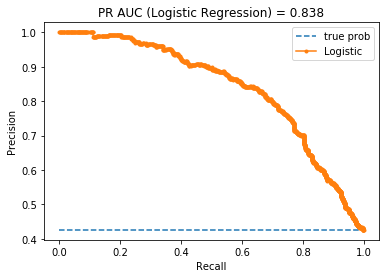

In [137]:
y_pred = evaluate_model(clean_pipeline, X_test, y_test, recall_th = 0.8)

In [138]:
key_words = top_features_lgr(clean_pipeline, 50)
key_words.head(10)

real             not_real          
        words      coef      words      coef
0   hiroshima  2.866882        you -2.771558
1        fire  2.668548       full -2.617753
2     suicide  2.627303         my -2.353770
3  california  2.589227        new -2.068283
4       train  2.539541        bag -1.879610
5     bombing  2.497915       your -1.715859
6          in  2.424485        let -1.682482
7    massacre  2.421812       ebay -1.673494
8    wildfire  2.385252  screaming -1.603046
9  earthquake  2.383361     blight -1.577443

In [139]:
pd.set_option('display.max_colwidth', 1000)

In [142]:
error_explor(df_train.text, X_test, y_test, y_pred, clean_pipeline, "TP")

Explore TP, index: 4056:

Sentance:
-----------------
 8-5-2015 - 4:30 P.M. - Progress Being Made on Boise Forest Fires
http://t.co/6o1mgMGHgt http://t.co/wTPO6elRZd 
-----------------
Sentance Token:
-----------------
 ['__date__', '__time__', 'progress', 'being', 'made', 'on', 'boise', 'forest', 'fires', '__url__', '__url__'] 
-----------------
Features:
-----------------
         word      coef
7    __date__  1.152780
10   __time__  0.455609
13    __url__  0.465704
84      being  0.125169
287    forest  1.850696
425      made -0.699395
503        on  0.586801

Prediction:
	0	1
------------------------------
[0.1577444 0.8422556]


### Random Forest on cleaned data

In [144]:
gbm_pipeline = Pipeline(steps=[('lemma', Lemmatizer()), 
                               ('preprocess', TfidfVectorizer(max_features=800, min_df=3, encoding='latin-1', analyzer='word', stop_words=None, ngram_range=(1, 3))),
                               ('gbm', GradientBoostingClassifier(random_state=43))])

gbm_param_space = {'preprocess__min_df': list(range(2, 5)),
                   'preprocess__ngram_range': [(1, 1), (2, 2), (3,3), (4, 4), (1, 5)],
                   'preprocess__stop_words': [None, 'english'],
                   'preprocess__max_features': [10, 200, 400, 800, 1000],
                   'gbm__learning_rate': stats.uniform(0.02, 0.28),
                   'gbm__n_estimators': stats.randint(300, 701),
                   'gbm__max_depth': list(range(2, 6)),
                   'gbm__subsample': stats.uniform(0.7, 0.3),
                   'gbm__max_features': ['sqrt', 'log2', None]}

In [145]:
grd_rf = RandomizedSearchCV(gbm_pipeline, gbm_param_space, cv=cv, n_iter=10, refit=True,random_state=45, return_train_score=False)
grd_rf.fit(X_train, y_train);

In [146]:
print('Mean cv score of best estimator={}'.format(grd_rf.best_score_))
print('Best params={}'.format(grd_rf.best_params_))

Mean cv score of best estimator=0.7725779967159279
Best params={'gbm__learning_rate': 0.037968242870505875, 'gbm__max_depth': 5, 'gbm__max_features': 'log2', 'gbm__n_estimators': 554, 'gbm__subsample': 0.9504512719569875, 'preprocess__max_features': 800, 'preprocess__min_df': 2, 'preprocess__ngram_range': (1, 5), 'preprocess__stop_words': 'english'}


For recall of 0.8 the precision is: 0.610
For recall of 0.8 the threshold is: 0.348
PC AUC: 0.823


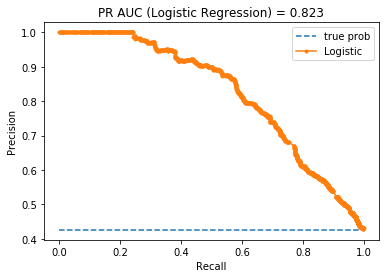

In [147]:
 y_pred_gbm = evaluate_model(grd_rf, X_test, y_test, recall_th = 0.8)

In [148]:
top_features_boost(grd_rf.best_estimator_, n=50).head(10)

,word,importance
0,__url__,0.077156
1,california,0.017747
2,__m__,0.016936
3,hiroshima,0.016145
4,train,0.015589
5,suicide,0.014138
6,killed,0.013366
7,building,0.011905
8,migrant,0.011466
9,storm,0.011270


### Voting

In [149]:
voting_clf = VotingClassifier([('logistic', pipeline_lemma_lgr),
                               ('gbm', gbm_pipeline)],
                              voting="soft", flatten_transform=True)

voting_param_space = {}
for key, value in param_grid_lgr.items():
    voting_param_space['logistic__' + key] = value
for key, value in gbm_param_space.items():
    voting_param_space['gbm__' + key] = value

In [150]:
# voting_param_space

In [151]:
search_clf = RandomizedSearchCV(
    voting_clf, voting_param_space, n_iter=10, cv=cv,
    refit=True, n_jobs=-1, random_state=51, return_train_score=False)

search_clf.fit(X_train, y_train);

In [152]:
print('Mean cv score of best estimator={}'.format(search_clf.best_score_))
print('Best params={}'.format(search_clf.best_params_))

Mean cv score of best estimator=0.7750410509031198
Best params={'gbm__gbm__learning_rate': 0.23129874971538886, 'gbm__gbm__max_depth': 4, 'gbm__gbm__max_features': 'sqrt', 'gbm__gbm__n_estimators': 650, 'gbm__gbm__subsample': 0.8747068241650562, 'gbm__preprocess__max_features': 800, 'gbm__preprocess__min_df': 3, 'gbm__preprocess__ngram_range': (1, 1), 'gbm__preprocess__stop_words': None, 'logistic__model__C': 10, 'logistic__model__penalty': 'l1', 'logistic__preprocess__max_features': 200, 'logistic__preprocess__min_df': 3, 'logistic__preprocess__ngram_range': (1, 1), 'logistic__preprocess__stop_words': 'english'}


For recall of 0.8 the precision is: 0.681
For recall of 0.8 the threshold is: 0.368
PC AUC: 0.835


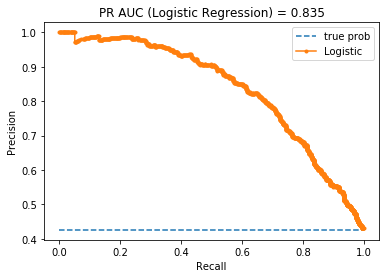

In [153]:
y_pred_vote = evaluate_model(search_clf, X_test, y_test, recall_th = 0.8)

## Interim findings and next steps based on basic model

The following insights were achieved as a result of the exploratory data analysis:

- The data normalization did not increase much the outcome of the model 
 
- Next steps, we would like to enrich the data by creating additonal features:
    - We can inspect the distribution of words with # and @ and use these as features
    - We can add the meta-features we created as additional features
    - Keywords - keywords that are common in emergency tweets are not common in non emergency tweets and vice versa.
    - Locations - locations that are common in emergency tweets are not common in non emergency tweets and vice versa.
 
- Another approach, is by using the text Context using LSTM model